# Proyecto Final - Introducción a la Ciencia de Datos
# Proyecto 2
## Clasificación de llamadas del C5
### M. Sc. Liliana Millán Núñez

Iván Oswaldo Salgado Velázquez 197704

Karina Lizette Gamboa Puente 197850

Octavio Fuentes Ortiz 150792

**Equipo 7**

---


# Proyecto 1

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from shapely import wkt
from datetime import datetime
import csv
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import requests
import os
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure

---

Cargamos la base de datos; la llamaremos *df*:

In [2]:
df = pd.read_csv('incidentes-viales-c5.csv')

---

### Transformación de variables

- Primero, trabajamos con las **fechas**:

In [3]:
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'], infer_datetime_format=True)
df['fecha_cierre'] = pd.to_datetime(df['fecha_cierre'], infer_datetime_format=True)

- Ahora, trabajamos con las **variables categóricas**:

In [4]:
df['dia_semana']= df['dia_semana'].astype('category')
df['codigo_cierre']= df['codigo_cierre'].astype('category')
df['año_cierre']= df['año_cierre'].astype('category')
df['mes_cierre']= df['mes_cierre'].astype('category')
df['delegacion_inicio']= df['delegacion_inicio'].astype('category')
df['incidente_c4']= df['incidente_c4'].astype('category')
df['clas_con_f_alarma']= df['clas_con_f_alarma'].astype('category')
df['tipo_entrada']= df['tipo_entrada'].astype('category')
df['delegacion_cierre']= df['delegacion_cierre'].astype('category')
df['mes']= df['mes'].astype('category')

In [5]:
df_registro=  df.folio.str.split(pat='/', expand=True)
df_registro.columns = ['centro','fecha_creacion_cve','num']
df['fecha_creacion_folio']=  pd.to_datetime(df_registro['fecha_creacion_cve'], yearfirst= True )

Nuestra nueva variable **'fecha_creacion_folio'** queda así:

In [6]:
df[['folio','fecha_creacion_folio']]

,folio,fecha_creacion_folio
0,GA/160123/05714,2016-01-23
1,AO/160123/05826,2016-01-23
2,C4/160124/02187,2016-01-24
3,C4/160124/05723,2016-01-24
4,C4/160124/01334,2016-01-24
...,...,...
1383133,GA/201022/03443,2020-10-22
1383134,GA/201022/03492,2020-10-22
1383135,C5/201022/02030,2020-10-22
1383136,C5/201022/02039,2020-10-22


- No trabajaremos con todas las columnas que contiene inicialmente el *dataframe*, por lo tanto, seleccionamos las que son de nuestro interés y para esto **creamos un nuevo** ***dataframe***:

In [7]:
df_nueva = df[['folio',
'hora_creacion',
'dia_semana',
'codigo_cierre' ,
'año_cierre',
'mes_cierre',
'hora_cierre',
'delegacion_inicio',
'incidente_c4',
'latitud',
'longitud',
'clas_con_f_alarma',
'tipo_entrada',
'delegacion_cierre',
'fecha_creacion_folio']]

- Ahora, transformaremos la variable *'codigo_cierre'*, quedándonos sólo con la letra de la descripción. Además, crearemos la variable ***'label'*** que es **1** cuando el código de cierre es **(F)** o **(N)** y **0** en otro caso:

In [8]:
df_a = df_nueva[df_nueva['codigo_cierre'] == '(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada']
df_a['label'] = 0
df_a['codigo_cierre'] = 'A'

df_i = df_nueva[df_nueva['codigo_cierre'] == '(I) El incidente reportado es afirmativo y se añade información adicional al evento']
df_i['label'] = 0
df_i['codigo_cierre'] = 'I'

df_d = df_nueva[df_nueva['codigo_cierre'] == '(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente']
df_d['label'] = 0
df_d['codigo_cierre'] = 'D'

df_n = df_nueva[df_nueva['codigo_cierre'] == '(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad']
df_n['label'] = 1
df_n['codigo_cierre'] = 'N'

df_f = df_nueva[df_nueva['codigo_cierre'] == '(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente' ]
df_f['label'] = 1
df_f['codigo_cierre'] = 'F'

In [9]:
df2 = df_a.append(df_n).append(df_f).append(df_d).append(df_i)

- Ahora, haremos limpieza para la variable ***hora_cierre***, que ordenada de manera ascendente, los datos a limpiar corresponden a los primeros **1,542** registros:

In [10]:
df_hc = df[['folio','hora_cierre']].sort_values('hora_cierre',ascending=True).head(1542)

In [11]:
df_hc['hora_cierre'] = df_hc['hora_cierre'].astype('float')

In [12]:
df_hc['hora_cierre_limpia'] = pd.to_timedelta(df_hc.hora_cierre,unit='days')

In [13]:
df_hc['hora_cierre_limpia']=df_hc['hora_cierre_limpia'].astype('str')

In [14]:
df_hc['hora_cierre_limpia'] = df_hc['hora_cierre_limpia'].str.split(pat=' ', expand=True).iloc[:,2].str.split(pat='.', expand=True).iloc[:,0]

In [15]:
df_hc_c = df[['folio','hora_cierre']].sort_values('hora_cierre',ascending=True).tail(1381596)

In [16]:
df_hc_c['hora_cierre_limpia'] = pd.to_datetime(df_hc_c['hora_cierre'], infer_datetime_format=True)

In [17]:
df_hc_c['hora_cierre_limpia']=df_hc_c['hora_cierre_limpia'].astype('str')

In [18]:
df_hc_c['hora_cierre_limpia'] = df_hc_c['hora_cierre_limpia'].str.split(pat=' ', expand=True).iloc[:,1]

In [19]:
df_hc_limpia= df_hc.append(df_hc_c)

In [20]:
df_hc_limpia['hora_cierre_limpia'] = pd.to_datetime(df_hc_limpia['hora_cierre_limpia'])

In [21]:
df_hc_limpia = df_hc_limpia.drop('hora_cierre', 1)

In [22]:
df2 = pd.merge(df2, df_hc_limpia, how = 'left', on = 'folio')

- Ahora, haremos limpieza para la variable ***hora_creacion***, que ordenada de manera ascendente, los datos a limpiar corresponden a los primeros **1,544** registros:

In [23]:
df_hc = df[['folio','hora_creacion']].sort_values('hora_creacion',ascending=True).head(1544)

In [24]:
df_hc['hora_creacion'] = df_hc['hora_creacion'].astype('float')

In [25]:
df_hc['hora_creacion_limpia'] = pd.to_timedelta(df_hc.hora_creacion,unit='days')

In [26]:
df_hc['hora_creacion_limpia']=df_hc['hora_creacion_limpia'].astype('str')

In [27]:
df_hc['hora_creacion_limpia'] = df_hc['hora_creacion_limpia'].str.split(pat=' ', expand=True).iloc[:,2].str.split(pat='.', expand=True).iloc[:,0]

In [28]:
df_hc_c = df[['folio','hora_creacion']].sort_values('hora_creacion',ascending=True).tail(1381594)

In [29]:
df_hc_c['hora_creacion_limpia'] = pd.to_datetime(df_hc_c['hora_creacion'], infer_datetime_format=True)

In [30]:
df_hc_c['hora_creacion_limpia']=df_hc_c['hora_creacion_limpia'].astype('str')

In [31]:
df_hc_c['hora_creacion_limpia'] = df_hc_c['hora_creacion_limpia'].str.split(pat=' ', expand=True).iloc[:,1]

In [32]:
df_hc_limpia= df_hc.append(df_hc_c)

In [33]:
df_hc_limpia['hora_creacion_limpia'] = pd.to_datetime(df_hc_limpia['hora_creacion_limpia'])

In [34]:
df_hc_limpia = df_hc_limpia.drop('hora_creacion', 1)

In [35]:
df2 = pd.merge(df2, df_hc_limpia, how = 'left', on = 'folio')

Para poder realizar una gráfica más adelante en nuestro **GEDA**, extraeremos la hora, para poder manejarlo como números enteros.

In [36]:
df2['hora_creacion_entera'] = df2['hora_creacion_limpia'].dt.hour

In [37]:
df2['minutos_creacion_entera'] = df2['hora_creacion_limpia'].dt.minute

- Ahora, haremos **limpieza** en las observaciones; quitamos tildes y dejamos todo en minúsculas:

In [38]:
cols = ['dia_semana','mes_cierre','delegacion_inicio','incidente_c4' ,'clas_con_f_alarma','tipo_entrada', 'delegacion_cierre']
df2[cols] = df2[cols].apply(lambda x: x.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

- Ahora, ***eliminamos*** las variables ***hora_creacion*** y ***hora_cierre***:

In [39]:
df2 = df2.drop(['hora_creacion', 'hora_cierre'], 1)

- Ahora, creamos una nueva variable ***año_creacion_folio***, obteniéndolo de la variable ***fecha_creacion_folio***:

In [40]:
df2['año_creacion_folio'] = df2['fecha_creacion_folio'].dt.year
df2.año_creacion_folio = df2.año_creacion_folio.astype('category')

- Ahora, convertimos ciertas variables a tipo *category*:

In [41]:
df2[['dia_semana','codigo_cierre','año_cierre','mes_cierre', 'delegacion_inicio', 'clas_con_f_alarma', 'tipo_entrada', 'delegacion_cierre'  , 'label', 'año_creacion_folio', 'incidente_c4']] = df2[['dia_semana','codigo_cierre','año_cierre','mes_cierre', 'delegacion_inicio', 'clas_con_f_alarma', 'tipo_entrada', 'delegacion_cierre'  , 'label', 'año_creacion_folio', 'incidente_c4']].astype('category')

---

## Imputación de Datos


Decidimos imputar **centroides**. Primero identificamos datos faltantes:

- En el caso de ***longitud***, tuvimos 435 observaciones vacías.

In [42]:
df2[df2['longitud'].isnull()]

,folio,dia_semana,codigo_cierre,año_cierre,mes_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,fecha_creacion_folio,label,hora_cierre_limpia,hora_creacion_limpia,hora_creacion_entera,minutos_creacion_entera,año_creacion_folio
105765,C5/181231/02638,lunes,A,2018,diciembre,tlahuac,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,tlahuac,2018-12-31,0,2020-12-06 12:34:37,2020-12-06 10:15:06,10,15,2018
105766,C5/181231/08753,lunes,A,2018,diciembre,iztapalapa,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,iztapalapa,2018-12-31,0,2020-12-06 23:27:46,2020-12-06 22:02:01,22,2,2018
105767,C5/181231/06427,lunes,A,2018,diciembre,xochimilco,lesionado-atropellado,NaN,NaN,urgencias medicas,llamada del 911,xochimilco,2018-12-31,0,2020-12-06 18:09:31,2020-12-06 17:43:26,17,43,2018
105768,C5/181231/09533,lunes,A,2018,diciembre,venustiano carranza,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,venustiano carranza,2018-12-31,0,2020-12-06 23:38:22,2020-12-06 23:29:01,23,29,2018
105769,C5/181231/01172,lunes,A,2018,diciembre,tlahuac,accidente-choque con lesionados,NaN,NaN,urgencias medicas,radio,milpa alta,2018-12-31,0,2020-12-06 08:10:43,2020-12-06 05:47:42,5,47,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169532,C5/181231/00076,lunes,D,2018,diciembre,iztapalapa,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,iztapalapa,2018-12-31,0,2020-12-06 00:11:34,2020-12-06 00:10:40,0,10,2018
1169536,C5/181231/02598,lunes,D,2018,diciembre,iztapalapa,accidente-choque sin lesionados,NaN,NaN,emergencia,llamada del 911,iztapalapa,2018-12-31,0,2020-12-06 10:14:18,2020-12-06 10:09:23,10,9,2018
1169538,C5/181231/07779,lunes,D,2018,diciembre,coyoacan,lesionado-atropellado,NaN,NaN,urgencias medicas,llamada del 911,coyoacan,2018-12-31,0,2020-12-06 20:22:20,2020-12-06 20:20:43,20,20,2018
1169558,C5/181231/06803,lunes,D,2018,diciembre,cuauhtemoc,detencion ciudadana-atropellado,NaN,NaN,delito,llamada del 911,cuauhtemoc,2018-12-31,0,2020-12-06 18:34:55,2020-12-06 18:27:50,18,27,2018


- En el caso de ***latitud***, tuvimos 443 observaciones vacías.

In [43]:
df2[df2['latitud'].isnull()]

,folio,dia_semana,codigo_cierre,año_cierre,mes_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,fecha_creacion_folio,label,hora_cierre_limpia,hora_creacion_limpia,hora_creacion_entera,minutos_creacion_entera,año_creacion_folio
105765,C5/181231/02638,lunes,A,2018,diciembre,tlahuac,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,tlahuac,2018-12-31,0,2020-12-06 12:34:37,2020-12-06 10:15:06,10,15,2018
105766,C5/181231/08753,lunes,A,2018,diciembre,iztapalapa,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,iztapalapa,2018-12-31,0,2020-12-06 23:27:46,2020-12-06 22:02:01,22,2,2018
105767,C5/181231/06427,lunes,A,2018,diciembre,xochimilco,lesionado-atropellado,NaN,NaN,urgencias medicas,llamada del 911,xochimilco,2018-12-31,0,2020-12-06 18:09:31,2020-12-06 17:43:26,17,43,2018
105768,C5/181231/09533,lunes,A,2018,diciembre,venustiano carranza,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,venustiano carranza,2018-12-31,0,2020-12-06 23:38:22,2020-12-06 23:29:01,23,29,2018
105769,C5/181231/01172,lunes,A,2018,diciembre,tlahuac,accidente-choque con lesionados,NaN,NaN,urgencias medicas,radio,milpa alta,2018-12-31,0,2020-12-06 08:10:43,2020-12-06 05:47:42,5,47,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169532,C5/181231/00076,lunes,D,2018,diciembre,iztapalapa,accidente-choque con lesionados,NaN,NaN,urgencias medicas,llamada del 911,iztapalapa,2018-12-31,0,2020-12-06 00:11:34,2020-12-06 00:10:40,0,10,2018
1169536,C5/181231/02598,lunes,D,2018,diciembre,iztapalapa,accidente-choque sin lesionados,NaN,NaN,emergencia,llamada del 911,iztapalapa,2018-12-31,0,2020-12-06 10:14:18,2020-12-06 10:09:23,10,9,2018
1169538,C5/181231/07779,lunes,D,2018,diciembre,coyoacan,lesionado-atropellado,NaN,NaN,urgencias medicas,llamada del 911,coyoacan,2018-12-31,0,2020-12-06 20:22:20,2020-12-06 20:20:43,20,20,2018
1169558,C5/181231/06803,lunes,D,2018,diciembre,cuauhtemoc,detencion ciudadana-atropellado,NaN,NaN,delito,llamada del 911,cuauhtemoc,2018-12-31,0,2020-12-06 18:34:55,2020-12-06 18:27:50,18,27,2018


Creamos el **diccionario** que utilizaremos para realizar la **imputación**:

In [44]:
dic_centroides = [ ['venustiano carranza' ,19.4304954545, -99.0931057959], 
                 ['cuajimalpa',19.3246343001, -99.3107285253], 
                 ['miguel hidalgo',19.4280623649, -99.2045669144], 
                 ['gustavo a. madero',19.5040652077, -99.1158642087], 
                 ['coyoacan',19.3266672536, -99.1503763525], 
                 ['iztapalapa',19.3491663204, -99.0567989642], 
                 ['cuauhtemoc',19.4313734294, -99.1490557562], 
                 ['benito juarez',19.3806424162, -99.1611346584], 
                 ['alvaro obregon',19.336175562, -99.246819712], 
                 ['tlalpan',19.1983396763, -99.2062207957], 
                 ['azcapotzalco',19.4853286147, -99.1821069423], 
                 ['iztacalco',19.396911897, -99.094329797], 
                 ['xochimilco',19.2451450458, -99.0903636045], 
                 ['tlahuac',19.2769983772, -99.0028216137], 
                 ['magdalena contreras',19.2689765031, -99.2684129061], 
                 ['milpa alta',19.1394565999, -99.0510954218] ]

In [45]:
df_centroides = DataFrame (dic_centroides,columns=['delegacion_inicio','lat','lon'])

In [46]:
df2 = pd.merge(df2, df_centroides, how='left', on = 'delegacion_inicio') 
df2['latitud'] = df2['latitud'].fillna(df2['lat'])
df2['longitud']= df2['longitud'].fillna(df2['lon'])

**Corroboramos** la imputación: 

In [47]:
df2[df2['latitud'].isnull()] # Ya no hay nulos en latitud
df2[df2['longitud'].isnull()] # Ya no hay nulos en longitud

,folio,dia_semana,codigo_cierre,año_cierre,mes_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,...,delegacion_cierre,fecha_creacion_folio,label,hora_cierre_limpia,hora_creacion_limpia,hora_creacion_entera,minutos_creacion_entera,año_creacion_folio,lat,lon


---

## *Feature Engineering*

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
import time 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

import pickle

**¿Qué variables debemos eliminar porque no las podremos tener en el momento de la predicción?**

Las variables que decidimos quitar son las siguientes, pues no se tendrán para el modelo:
- codigo_cierre
- año_cierre
- mes_cierre
- delegacion_cierre
- hora_cierre_limpia
- año_creacion_folio
- lat
- lon
- hora_creacion_limpia
- fecha_creacion_folio
- folio
- latitud
- longitud

Para poder tener un mejor manejo de los datos en pasos posteriores, **ordenamos** la base por ***año de registro***. 

In [49]:
df2.head(1)

,folio,dia_semana,codigo_cierre,año_cierre,mes_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,...,delegacion_cierre,fecha_creacion_folio,label,hora_cierre_limpia,hora_creacion_limpia,hora_creacion_entera,minutos_creacion_entera,año_creacion_folio,lat,lon
0,GA/160123/05714,sabado,A,2016,enero,venustiano carranza,accidente-choque sin lesionados,19.422113,-99.084643,emergencia,...,venustiano carranza,2016-01-23,0,2020-12-06 00:21:08,2020-12-06 22:35:04,22,35,2016,19.430495,-99.093106


In [50]:
df2['año_creacion_folio']=df2['año_creacion_folio'].astype('int64')

In [51]:
df2 = df2.sort_values(by = 'año_creacion_folio', axis=0)

In [52]:
df2.drop(['codigo_cierre', 'año_cierre', 'mes_cierre','delegacion_cierre',
           'hora_cierre_limpia',  'lat', 'lon', 'año_creacion_folio',
           'hora_creacion_limpia', 'fecha_creacion_folio', 'folio', 'latitud', 'longitud'], 
            axis = 1, inplace = True)

Las variables con las que sí nos quedamos para el modelo son:

In [53]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1383138 entries, 465620 to 1383137
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   dia_semana               1383138 non-null  category
 1   delegacion_inicio        1382980 non-null  object  
 2   incidente_c4             1383138 non-null  category
 3   clas_con_f_alarma        1383138 non-null  category
 4   tipo_entrada             1383138 non-null  category
 5   label                    1383138 non-null  category
 6   hora_creacion_entera     1383138 non-null  int64   
 7   minutos_creacion_entera  1383138 non-null  int64   
dtypes: category(5), int64(2), object(1)
memory usage: 48.8+ MB


**Creación de variables**


- ¿Qué variables relevantes puedes crear?

Creamos las siguientes variables: ***hora_creacion_entera, minutos_creacion_entera, sin_hr, cos_hr, sin_m*** y ***cos_m***.

**Selección de variables**

***Model selection***

***Hiperparameter tunning***

In [54]:
df2.isnull().sum()

dia_semana                   0
delegacion_inicio          158
incidente_c4                 0
clas_con_f_alarma            0
tipo_entrada                 0
label                        0
hora_creacion_entera         0
minutos_creacion_entera      0
dtype: int64

In [55]:
df2['delegacion_inicio'].fillna('iztapalapa', inplace = True)
df2.isnull().sum()

dia_semana                 0
delegacion_inicio          0
incidente_c4               0
clas_con_f_alarma          0
tipo_entrada               0
label                      0
hora_creacion_entera       0
minutos_creacion_entera    0
dtype: int64

Las **implicaciones** de nuestra imputación consideramos que son:

- Posible asociación de llamadas falsas a la delegación **Iztapalapa**.


- Una segunda opción podría ser, eliminar los registros de las delegaciones faltantes, considerando que es menos de 1%.


---

- Transformaciones cíclicas

In [56]:
# converting the hour into a sin, cos coordinate
HOURS = 24
df2['sin_hr'] = np.sin(2*np.pi*df2.hora_creacion_entera/HOURS)
df2['cos_hr'] = np.cos(2*np.pi*df2.hora_creacion_entera/HOURS)
df2.head(1)

,dia_semana,delegacion_inicio,incidente_c4,clas_con_f_alarma,tipo_entrada,label,hora_creacion_entera,minutos_creacion_entera,sin_hr,cos_hr
465620,martes,cuauhtemoc,accidente-choque con lesionados,urgencias medicas,radio,0,21,16,-0.707107,0.707107


In [57]:
# converting the minutes into a sin, cos coordinate
MINUTES = 60
df2['sin_m'] = np.sin(2*np.pi*df2.minutos_creacion_entera/MINUTES)
df2['cos_m'] = np.cos(2*np.pi*df2.minutos_creacion_entera/MINUTES)
df2.head(1)

,dia_semana,delegacion_inicio,incidente_c4,clas_con_f_alarma,tipo_entrada,label,hora_creacion_entera,minutos_creacion_entera,sin_hr,cos_hr,sin_m,cos_m
465620,martes,cuauhtemoc,accidente-choque con lesionados,urgencias medicas,radio,0,21,16,-0.707107,0.707107,0.994522,-0.104528


- Se colapsan categorías dentro de la variable ***tipo_entrada***, dado que **llamada del 066** se convirtió en **911**, a partir del 2017.

In [58]:
# Colapse de variables
df2["tipo_entrada"].unique()

['radio', 'llamada del 066', 'camara', 'boton de auxilio', 'redes', 'llamada del 911', 'llamada app911', 'zello', 'aplicativos']
Categories (9, object): ['radio', 'llamada del 066', 'camara', 'boton de auxilio', ..., 'llamada del 911', 'llamada app911', 'zello', 'aplicativos']

In [59]:
df2.tipo_entrada = np.where(df2.tipo_entrada.isin(['llamada del 066']), 'llamada del 911', df2.tipo_entrada )

In [60]:
df2["tipo_entrada"].unique()

array(['radio', 'llamada del 911', 'camara', 'boton de auxilio', 'redes',
       'llamada app911', 'zello', 'aplicativos'], dtype=object)

In [61]:
df2.drop(['hora_creacion_entera', 'minutos_creacion_entera'],axis = 1, inplace = True)

## *One Hot Enconding*

**NOTA**: Para realizar ***One Hot Encoding*** y tomar variables importantes decidimos utilizar una muestra de los datos: 

In [62]:
df_HOE =  df2.sample(n=200000)
df_HOE.shape

(200000, 10)

In [63]:
nombres = [sorted(df_HOE.dia_semana.unique()),
sorted(df_HOE.delegacion_inicio.unique()),
sorted(df_HOE.incidente_c4.unique()),
sorted(df_HOE.clas_con_f_alarma.unique()),
sorted(df_HOE.tipo_entrada.unique())]

In [64]:
transformers_1 = [('one_hot', OneHotEncoder(sparse = False, categories = "auto"), 
                   ['dia_semana', 'delegacion_inicio', 'incidente_c4',
                    'clas_con_f_alarma', 'tipo_entrada'])    ]

In [65]:
col_trans_1 = ColumnTransformer(transformers_1, remainder="passthrough", n_jobs=-1, verbose=True)

In [66]:
col_trans_1.fit(df_HOE.drop('label',1))

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(sparse=False),
                                 ['dia_semana', 'delegacion_inicio',
                                  'incidente_c4', 'clas_con_f_alarma',
                                  'tipo_entrada'])],
                  verbose=True)

In [67]:
df_HOE_input_vars = col_trans_1.transform(df_HOE.drop('label',1))

In [68]:
columnas = col_trans_1.get_feature_names( )

In [69]:
df_model = pd.DataFrame( df_HOE_input_vars, columns=columnas )

In [70]:
df_model.head()

,one_hot__x0_domingo,one_hot__x0_jueves,one_hot__x0_lunes,one_hot__x0_martes,one_hot__x0_miercoles,one_hot__x0_sabado,one_hot__x0_viernes,one_hot__x1_alvaro obregon,one_hot__x1_azcapotzalco,one_hot__x1_benito juarez,...,one_hot__x4_camara,one_hot__x4_llamada app911,one_hot__x4_llamada del 911,one_hot__x4_radio,one_hot__x4_redes,one_hot__x4_zello,sin_hr,cos_hr,sin_m,cos_m
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-9.659258e-01,-2.588190e-01,-0.669131,-0.743145
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-1.000000e+00,-1.836970e-16,-0.809017,0.587785
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,7.071068e-01,7.071068e-01,-0.994522,-0.104528
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.224647e-16,-1.000000e+00,0.913545,0.406737
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-2.588190e-01,-9.659258e-01,0.743145,0.669131


- Generando un ***RandomForest*** utilizando ***GridSearchCV*** generando al menos 10 modelos diferentes ***-CV*** puede tener ***temporal CV-*** y utilizando eficiencia como la métrica de desempeño para seleccionar al "mejor modelo".

In [71]:
X = df_HOE_input_vars
y = df_HOE.label.values

In [72]:
X.shape

(200000, 63)

In [73]:
np.random.seed(130295)

In [74]:
# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)

In [75]:
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [76]:
hyper_param_grid = {'n_estimators': [300, 500], 
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [10, 20]}

In [77]:
# ocupemos grid search!
gs = GridSearchCV(classifier, 
                 hyper_param_grid, 
                 scoring = 'precision',
                 cv = 5, 
                 n_jobs = -1)
start_time = time.time()
gs.fit(X, y)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  1809.8779802322388


In [78]:
#pickle.dump(gs, open("gs.pkl", "wb"))

* Se utiliza el mejor estimador para elegir seleccionar las variables de interes: 

In [79]:
importance = gs.best_estimator_.feature_importances_

In [80]:
a=[]
for i,v in enumerate(importance):
   a.append('Feature: %0d, Score: %.5f' % (i,v))

In [81]:
importance = pd.concat([pd.DataFrame(columnas), pd.DataFrame(a)], axis=1)
importance['score'] = importance.iloc[:, 1].str.split(pat=':', expand=True).iloc[:,  2] 
importance.columns = ['variables', 'lista','score']
importance['score'] = importance['score'].astype('float')

In [82]:
importance

,variables,lista,score
0,one_hot__x0_domingo,"Feature: 0, Score: 0.00020",0.00020
1,one_hot__x0_jueves,"Feature: 1, Score: 0.00019",0.00019
2,one_hot__x0_lunes,"Feature: 2, Score: 0.00010",0.00010
3,one_hot__x0_martes,"Feature: 3, Score: 0.00013",0.00013
4,one_hot__x0_miercoles,"Feature: 4, Score: 0.00014",0.00014
...,...,...,...
58,one_hot__x4_zello,"Feature: 58, Score: 0.00064",0.00064
59,sin_hr,"Feature: 59, Score: 0.01033",0.01033
60,cos_hr,"Feature: 60, Score: 0.00420",0.00420
61,sin_m,"Feature: 61, Score: 0.00064",0.00064


- **Elimina** aquellas variables que aportan **menos del 7%** de información y se deja el dataset final:

In [83]:
LISTA_IMPORTANTES = importance[importance.score >= 0.07]['variables'].unique()

In [84]:
LISTA_IMPORTANTES

array(['one_hot__x2_accidente-choque sin lesionados',
       'one_hot__x3_emergencia', 'one_hot__x3_falsa alarma',
       'one_hot__x3_urgencias medicas', 'one_hot__x4_llamada del 911'],
      dtype=object)

Ahora, aplicamos la selección a **toda la base**:

In [85]:
col_trans_1.fit(df2.drop('label',1))

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(sparse=False),
                                 ['dia_semana', 'delegacion_inicio',
                                  'incidente_c4', 'clas_con_f_alarma',
                                  'tipo_entrada'])],
                  verbose=True)

In [86]:
df2_input_vars = col_trans_1.transform(df2.drop('label',1))

In [87]:
columnas = col_trans_1.get_feature_names( )

In [88]:
df_final = pd.DataFrame(df2_input_vars, columns=columnas )

In [89]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383138 entries, 0 to 1383137
Data columns (total 64 columns):
 #   Column                                                     Non-Null Count    Dtype  
---  ------                                                     --------------    -----  
 0   one_hot__x0_domingo                                        1383138 non-null  float64
 1   one_hot__x0_jueves                                         1383138 non-null  float64
 2   one_hot__x0_lunes                                          1383138 non-null  float64
 3   one_hot__x0_martes                                         1383138 non-null  float64
 4   one_hot__x0_miercoles                                      1383138 non-null  float64
 5   one_hot__x0_sabado                                         1383138 non-null  float64
 6   one_hot__x0_viernes                                        1383138 non-null  float64
 7   one_hot__x1_alvaro obregon                                 1383138 non-n

In [90]:
b = df_final[LISTA_IMPORTANTES].reset_index(drop=True)
a = df2[["label"]].reset_index(drop=True)

In [91]:
DF_FINAL = pd.concat([a,b], axis=1)

In [92]:
DF_FINAL

,label,one_hot__x2_accidente-choque sin lesionados,one_hot__x3_emergencia,one_hot__x3_falsa alarma,one_hot__x3_urgencias medicas,one_hot__x4_llamada del 911
0,0,0.0,0.0,0.0,1.0,0.0
1,0,1.0,1.0,0.0,0.0,1.0
2,0,0.0,0.0,0.0,1.0,1.0
3,0,1.0,1.0,0.0,0.0,1.0
4,0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
1383133,0,0.0,0.0,0.0,1.0,1.0
1383134,0,1.0,1.0,0.0,0.0,1.0
1383135,0,0.0,0.0,0.0,1.0,1.0
1383136,0,1.0,1.0,0.0,0.0,1.0


---

# Proyecto 2

## Modelado

A continuación, utilizando un ***magic loop***, generamos los algoritmos de ***decision tree*** y ***random forest***.


Recordemos  que el criterio de selección de **mejor modelo** será la **eficiencia** del modelo.

In [93]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [94]:
#DF_MUESTRA = DF_FINAL.sample(n = 500000)

In [95]:
#X1 =  DF_MUESTRA.drop('label',1).values
#y1 =  DF_MUESTRA.label.values

In [96]:
X1 =  DF_FINAL.drop('label',1).values
y1 =  DF_FINAL.label.values

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, shuffle= False)

In [98]:
algorithms_dict = {'tree': 'tree_grid_search',
                  'random_forest': 'rf_grid_search'}

In [99]:
grid_search_dict = {'tree_grid_search': {'max_depth': [5, 10, 15 ], 
                                         'min_samples_leaf': [3,7, 5 ]},
                   'rf_grid_search': {'n_estimators': [500,800],  
                                      'max_depth': [5,10], 
                                      'min_samples_leaf': [10,15]}}

In [100]:
estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111),
                  'random_forest': RandomForestClassifier(oob_score=True, random_state=2222)}

In [101]:
def magic_loop(algorithms, features, labels):
    best_estimators = []
    
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        
        
        tscv = TimeSeriesSplit(n_splits=5 )
        gs = GridSearchCV(estimator, 
                          grid_params, 
                          scoring='precision', 
                          cv=tscv, 
                          n_jobs=-1)
        
        #train
        gs.fit(features, labels)
        #best estimator
        best_estimators.append(gs)
        
        
    return best_estimators

In [102]:
algorithms = ['tree', 'random_forest']

In [103]:
best = magic_loop(algorithms, X_train, y_train)

In [104]:
best[1].best_estimator_

RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=500,
                       oob_score=True, random_state=2222)

Seleccionamos el mejor modelo para:
    
- ***Random forest***

In [105]:
# El mejor de Random
best_rf = best[1].best_estimator_
best_rf

RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=500,
                       oob_score=True, random_state=2222)

In [106]:
best_rf.n_features_

5

In [107]:
best_rf.oob_score_

0.8042633510482932

In [108]:
best_rf.feature_importances_

array([0.18872312, 0.12307841, 0.337225  , 0.09408516, 0.25688831])

In [109]:
# predicciones con el mejor predictor 
predicted_labels_rf = best_rf.predict(X_test)
predicted_labels_rf

array([0, 0, 0, ..., 0, 0, 0])

In [110]:
predicted_labels_rf.sum()

1342

In [111]:
# predicciones en score con el mejor predictor
predicted_scores_rf = best_rf.predict_proba(X_test)
predicted_scores_rf

array([[0.85785582, 0.14214418],
       [0.72069219, 0.27930781],
       [0.72069219, 0.27930781],
       ...,
       [0.85785582, 0.14214418],
       [0.72069219, 0.27930781],
       [0.93461773, 0.06538227]])

- ***Decision tree***

In [112]:
# El mejor de Tree
best_dt = best[0].best_estimator_
best_dt

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=1111)

In [113]:
best_dt.n_features_

5

In [114]:
best_dt.feature_importances_

array([2.90316773e-01, 1.50032919e-03, 4.48930362e-01, 1.00520643e-04,
       2.59152015e-01])

In [115]:
#feature_importance = pd.DataFrame({'importance': best_dt.feature_importances_,
#                                  'feature': X1.columns.values})

In [116]:
# predicciones con el mejor predictor 
predicted_labels_dt = best_dt.predict(X_test)
predicted_labels_dt

array([0, 0, 0, ..., 0, 0, 0])

In [117]:
predicted_labels_dt.sum()

1342

In [118]:
# predicciones en score con el mejor predictor
predicted_scores_dt = best_dt.predict_proba(X_test)
predicted_scores_dt

array([[0.85783609, 0.14216391],
       [0.72071287, 0.27928713],
       [0.72071287, 0.27928713],
       ...,
       [0.85783609, 0.14216391],
       [0.72071287, 0.27928713],
       [0.93462663, 0.06537337]])

---
## Evaluación de modelo

Generamos la **curva ROC**: 

In [119]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [120]:
np.sum(predicted_scores_rf == predicted_scores_dt)

2450

- ***Random forest***

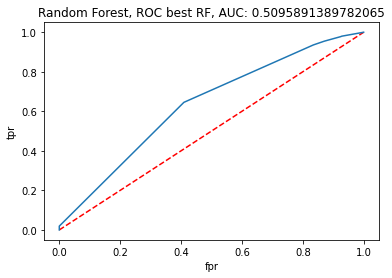

In [121]:
%matplotlib inline

fpr_rf, tpr_rf, thresholds_rf_rocauc = roc_curve(y_test, predicted_scores_rf[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr_rf, tpr_rf)
plt.title("Random Forest, ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels_rf)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

***Accuracy***

In [122]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted_labels_rf)

0.8015153925126886

In [123]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, predicted_scores_rf[:,1], pos_label=1)

In [124]:
thresholds_rf = np.append(thresholds_rf, 1)

In [125]:
(precision_rf.shape, recall_rf.shape, thresholds_rf.shape)

((12,), (12,), (12,))

- ***Decision tree***

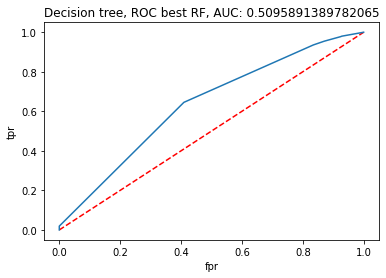

In [126]:
%matplotlib inline

fpr_dt, tpr_dt, thresholds_dt_rocauc = roc_curve(y_test, predicted_scores_dt[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr_dt, tpr_dt)
plt.title("Decision tree, ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels_dt)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

***Accuracy***

In [127]:
accuracy_score(y_test, predicted_labels_dt)

0.8015153925126886

In [128]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, predicted_scores_dt[:,1], pos_label=1)

In [129]:
thresholds_dt = np.append(thresholds_dt, 1)

In [130]:
(precision_dt.shape, recall_dt.shape, thresholds_dt.shape)

((12,), (12,), (12,))

**Tablas de métricas** del modelo y la **eficiencia** y **cobertura** en cada punto de corte:

In [131]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

- ***Random forest***

In [132]:
metrics_report_rf = get_metrics_report(fpr_rf, tpr_rf, thresholds_rf_rocauc, precision_rf, recall_rf, thresholds_rf)
metrics_report_rf

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.055836,0.202366,1.000000,0.336612,1.000000,1.000000,0.000000,0.000000
1,0.062398,0.211269,0.980136,0.347611,0.980136,0.928349,0.071651,0.019864
2,0.065382,0.211597,0.977621,0.347896,0.977621,0.924147,0.075853,0.022379
3,0.115554,0.217684,0.954698,0.354530,0.954698,0.870472,0.129528,0.045302
4,0.129483,0.221414,0.935920,0.358109,0.935920,0.834973,0.165027,0.064080
5,0.142144,0.221431,0.935920,0.358132,0.935920,0.834890,0.165110,0.064080
6,0.188321,0.285606,0.645602,0.396018,0.645602,0.409702,0.590298,0.354398
7,0.279308,0.285701,0.644759,0.395951,0.644759,0.408977,0.591023,0.355241
8,0.989176,1.000000,0.019178,0.037635,0.019178,0.000000,1.000000,0.980822
9,0.993326,1.000000,0.018221,0.035789,0.018221,0.000000,1.000000,0.981779


- ***Decision tree***

In [133]:
metrics_report_dt = get_metrics_report(fpr_dt, tpr_dt, thresholds_dt_rocauc, precision_dt, recall_dt, thresholds_dt)
metrics_report_dt

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.055900,0.202366,1.000000,0.336612,1.000000,1.000000,0.000000,0.000000
1,0.062256,0.211269,0.980136,0.347611,0.980136,0.928349,0.071651,0.019864
2,0.065373,0.211597,0.977621,0.347896,0.977621,0.924147,0.075853,0.022379
3,0.115503,0.217684,0.954698,0.354530,0.954698,0.870472,0.129528,0.045302
4,0.133333,0.221414,0.935920,0.358109,0.935920,0.834973,0.165027,0.064080
5,0.142164,0.221431,0.935920,0.358132,0.935920,0.834890,0.165110,0.064080
6,0.188571,0.285606,0.645602,0.396018,0.645602,0.409702,0.590298,0.354398
7,0.279287,0.285701,0.644759,0.395951,0.644759,0.408977,0.591023,0.355241
8,0.989362,1.000000,0.019178,0.037635,0.019178,0.000000,1.000000,0.980822
9,0.993311,1.000000,0.018221,0.035789,0.018221,0.000000,1.000000,0.981779


Después de haber observado los mejores modelos y las tablas de métricas, decidimos, que trabajaremos con el ***decision tree***; dado que los ***scores*** son los mismos, optamos por el modelo más simple (computacionalmente).

Generamos la curva de ***precision recall*** con el modelo seleccionado (incluyendo línea en nuestra **k**)

Definimos las funciones para calcular:
    
- ***Presicion@k***

In [134]:
from sklearn.metrics import precision_score, recall_score

In [135]:
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

- ***Recall@k***

In [136]:
def recall_at_k(y_true, y_scores, k):
   threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
   y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

   return recall_score(y_true, y_pred)

In [137]:
def get_top_k(y_true,y_scores,k):
    gt=pd.DataFrame([y_scores,y_true]).T
    gt.columns = ['pred', 'real']
    top = gt.sort_values('pred')[:int(k*len(y_scores))]
      
    return top

In [139]:
y_scores = predicted_scores_dt[:,1]

In [140]:
gt = pd.DataFrame([y_scores,y_test]).T
gt.columns = ['pred', 'real']
top = gt.sort_values('pred')[:int(1*len(y_scores))]

In [141]:
top

,pred,real
85459,0.0559,0.0
268705,0.0559,0.0
316505,0.0559,0.0
268701,0.0559,0.0
268699,0.0559,0.0
...,...,...
70612,1.0000,1.0
70613,1.0000,1.0
85333,1.0000,1.0
70615,1.0000,1.0


In [186]:
top_k=get_top_k(y_test, y_scores, 15)
top_k

,pred,real
85459,0.0559,0.0
268705,0.0559,0.0
316505,0.0559,0.0
268701,0.0559,0.0
268699,0.0559,0.0
...,...,...
70612,1.0000,1.0
70613,1.0000,1.0
85333,1.0000,1.0
70615,1.0000,1.0


Definimos la función para graficar la ***precision-recall@k curve***:

In [145]:
np.arange(0.001, 0.9,  0.05)

array([0.001, 0.051, 0.101, 0.151, 0.201, 0.251, 0.301, 0.351, 0.401,
       0.451, 0.501, 0.551, 0.601, 0.651, 0.701, 0.751, 0.801, 0.851])

In [146]:
def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.1, 1.1,  0.2))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        top_k = get_top_k(y_true, y_scores, k)
        d['precision'] = precision_at_k(top_k.iloc[:,1], top_k.iloc[:,0],k)
        d['recall'] = recall_at_k(top_k.iloc[:,1], top_k.iloc[:,0],k)

        pr_k = pr_k.append(d, ignore_index=True)
        

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.axvline(x = 0.0361, linewidth=2, color='r', label='k', ls=':')
    plt.legend()
    plt.xlabel('k%')
    plt.ylabel('best value')

    if save_target is not None:
        plt.savefig(save_target, dpi=300)

    return pr_k

,k,precision,recall
0,0.1,0.083781,0.392788
1,0.3,0.170092,0.670778
2,0.5,0.111509,0.753423
3,0.7,0.209003,0.899502
4,0.9,0.216245,0.975531


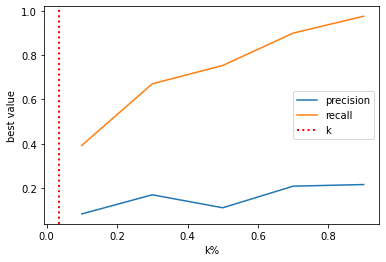

In [147]:
pr_k_curve(y_test,y_scores, None)

Calculamos la **k**, para esto, debemos obtener el **promedio de cuántos incidentes tenemos por día**:

In [148]:
k = round(df_nueva.groupby('fecha_creacion_folio').count().folio.mean())
k

554

In [149]:
y_test

[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]
Length: 345785
Categories (2, int64): [0, 1]

Ahora, sabemos que estos **554** incidentes por día **son nuestro 100%** y que de éste, **sólo podemos atender 20 casos** (pues sólo tenemos 20 ambulancias y suponemos que todos las requieren) que necesiten el servicio.

**NOTA**: Para las siguientes dos preguntas, suponemos que abarcamos el 3.61%, que corresponde a poder actuar con las 20 ambulancias, para las 554 alertas diarias promedio.


¿Cuánto tienes de **cobertura@k**?

In [150]:
round(recall_at_k(y_test, y_scores, .0361),4)

0.6448

¿Cuánto tienes de **eficiencia@k**?

In [151]:
round(precision_at_k(y_test, y_scores, .0361),4)

0.2857

¿Cuál es la **cobertura máxima** que se puede tener con la **k** que tienes? Tomando en cuenta la respuesta a esta pregunta, **tu modelo ¿es bueno? ¿es malo?**



- Creemos que nuestro modelo va en buen camino, dado que cubre un 64% de las posibles llamadas falsas; esto da apaertura a que menos ambulancias sean enviadas a dar el servicio a una falsa alarma.

---

Se decidió cambiar el **punto de corte** de 0.5 a **0.18**, buscando abarcar un mayor número de probables llamadas falsas (***recall***).


Con ello se busca evitar utilizar el servicio de ambulancia en una alerta falsa, sin tener que ser sometido a una revisión más detallada.


Para la toma de esta decisión se supone que el C5 tiene una capacidad de revisión de llamadas de al menos el 50% de las entrantes, dado que en promedio se reciben 554 por día, se estarían revisando 253 llamadas (por ejemplo, mediante cámaras).

In [152]:
score =pd.DataFrame(predicted_scores_dt[:,1], columns =['score'])
real= pd.DataFrame(y_test, columns=['real'])
df_test =  pd.concat([score,real], axis=1)
df_test['prediccion']= np.where(df_test['score'] < .17,0,1)

In [153]:
#pd.DataFrame(df_test[['real','prediccion']].value_counts())

CM=pd.crosstab(df_test.prediccion,df_test.real, margins=True)
CM

real,0,1,All
prediccion,,,
0,162810,24799,187609
1,113000,45176,158176
All,275810,69975,345785


In [154]:
# precision
print(round(CM.iloc[1,1]/CM.iloc[1,2], 2))

#recall
print(round(CM.iloc[1,1]/CM.iloc[2,1], 2))

#Cuántas falsas?
print(round(CM.iloc[1,2]/CM.iloc[2,2],2))

#Cuántas llamadas al día tendrian que revisarse?
print(round(554*(CM.iloc[1,2]/CM.iloc[2,2])))

0.29
0.65
0.46
253


---
## Sesgo e Inequidad

In [155]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

Utilizando el *feature* ***delegación*** como **atributo protegido**:

**NOTA**: Antes de empezar, armamos nuestro *data frame* para el análisis de sesgo y equidad*:

In [156]:
df_test

,score,real,prediccion
0,0.142164,0,0
1,0.279287,0,1
2,0.279287,0,1
3,0.279287,0,1
4,0.279287,0,1
...,...,...,...
345780,0.142164,0,0
345781,0.279287,0,1
345782,0.142164,0,0
345783,0.279287,0,1


In [157]:
delegacion_aequitas = pd.DataFrame(df2.tail(345785).delegacion_inicio)

In [158]:
delegacion_aequitas = delegacion_aequitas.reset_index(drop=True)

In [159]:
aequitas = pd.concat([df_test,delegacion_aequitas], axis=1)

In [160]:
aequitas = aequitas.drop('score',1)


In [161]:
aequitas

,real,prediccion,delegacion_inicio
0,0,0,cuauhtemoc
1,0,1,iztacalco
2,0,1,gustavo a. madero
3,0,1,xochimilco
4,0,1,gustavo a. madero
...,...,...,...
345780,0,0,coyoacan
345781,0,1,tlalpan
345782,0,0,gustavo a. madero
345783,0,1,gustavo a. madero


In [162]:
aequitas.columns = ['label_value','score','delegacion_inicio']

In [163]:
aequitas

,label_value,score,delegacion_inicio
0,0,0,cuauhtemoc
1,0,1,iztacalco
2,0,1,gustavo a. madero
3,0,1,xochimilco
4,0,1,gustavo a. madero
...,...,...,...
345780,0,0,coyoacan
345781,0,1,tlalpan
345782,0,0,gustavo a. madero
345783,0,1,gustavo a. madero


**a.** Selecciona **3 métricas adecuadas** de acuerdo a los objetivos y acciones. Justifica.


Las **métricas** que **seleccionamos** son:

- ***Recall Parity***: la interpretamos de la siguiente manera; la probabilidad de clasificar una llamada como falsa dada su delegación y que realmente haya sido falsa. Seleccionamos la métrica porque al contar con **recursos limitados** (ambulancias), debemos asegurarnos no gastar recursos con quien no los necesita.


- ***FOR Parity***: la interpretamos de la siguiente manera; la probabilidad de que hayamos clasificado una llamada como falsa dada su delegación y que la alerta haya sido verdadera. Seleccionamos la métrica porque nos interesa minimizar los casos donde discriminemos falsas las llamadas dada su delegación, siendo que sí necesitan el servicio.


- ***FNR Parity***: la interpretamos de la siguiente manera; dado que se recibe una alerta falsa, cuál es la probabilidad de que hayamos enviado una ambulancia dado la delegación a la que pertenece la llamada. Seleccionamos la métrica porque queremos verificar si alguna delegación tiene ventaja sobre otra.

**b.** Define cuál es tu **grupo de referencia**. Justifica.


Seleccionamos como nuestro grupo de referencia a Iztapalapa, pues es el grupo de mayor tamaño entre todos los grupos existentes. Además de que por medio de la moda, fue el grupo que imputamos en los valores faltantes.


**c.** Cuantifica el sesgo e inquedidad sobre los grupos de este atributo:

- Las tablas de métricas obtenidas de la clase Group de Aequitas (conteos de frecuencias y absolutas)

In [164]:
g = Group()
xtab, attrbs = g.get_crosstabs(aequitas)

model_id, score_thresholds 0 {'rank_abs': [158176]}


In [165]:
absolute_metrics = g.list_absolute_metrics(xtab)

**Conteos por grupo**:

- Frecuencias

In [166]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,158176,delegacion_inicio,alvaro obregon,11963,12748,8240,1904,10844,3723,5627,19084,24711,345785
1,0,binary 0/1,158176,delegacion_inicio,azcapotzalco,6772,8272,5215,891,7381,1557,2448,12596,15044,345785
2,0,binary 0/1,158176,delegacion_inicio,benito juarez,11830,14009,9064,1368,12641,2766,4134,21705,25839,345785
3,0,binary 0/1,158176,delegacion_inicio,coyoacan,13034,13323,9124,1759,11564,3910,5669,20688,26357,345785
4,0,binary 0/1,158176,delegacion_inicio,cuajimalpa,2543,4024,1438,1079,2945,1105,2184,4383,6567,345785
5,0,binary 0/1,158176,delegacion_inicio,cuauhtemoc,13293,21065,10274,2021,19044,3019,5040,29318,34358,345785
6,0,binary 0/1,158176,delegacion_inicio,gustavo a. madero,15416,19080,11101,2340,16740,4315,6655,27841,34496,345785
7,0,binary 0/1,158176,delegacion_inicio,iztacalco,6473,8182,4617,989,7193,1856,2845,11810,14655,345785
8,0,binary 0/1,158176,delegacion_inicio,iztapalapa,28338,29621,19372,4361,25260,8966,13327,44632,57959,345785
9,0,binary 0/1,158176,delegacion_inicio,magdalena contreras,2657,2837,1662,507,2330,995,1502,3992,5494,345785


- Absolutos

In [167]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion_inicio,alvaro obregon,0.66,0.57,0.15,0.69,0.43,0.34,0.85,0.31,0.08,0.48,0.23
1,delegacion_inicio,azcapotzalco,0.64,0.59,0.11,0.77,0.41,0.36,0.89,0.23,0.04,0.45,0.16
2,delegacion_inicio,benito juarez,0.67,0.58,0.10,0.77,0.42,0.33,0.90,0.23,0.07,0.46,0.16
3,delegacion_inicio,coyoacan,0.69,0.56,0.13,0.70,0.44,0.31,0.87,0.30,0.08,0.49,0.22
4,delegacion_inicio,cuajimalpa,0.51,0.67,0.27,0.57,0.33,0.49,0.73,0.43,0.02,0.39,0.33
5,delegacion_inicio,cuauhtemoc,0.60,0.65,0.10,0.77,0.35,0.40,0.90,0.23,0.08,0.39,0.15
6,delegacion_inicio,gustavo a. madero,0.65,0.60,0.12,0.72,0.40,0.35,0.88,0.28,0.10,0.45,0.19
7,delegacion_inicio,iztacalco,0.65,0.61,0.12,0.71,0.39,0.35,0.88,0.29,0.04,0.44,0.19
8,delegacion_inicio,iztapalapa,0.67,0.57,0.15,0.68,0.43,0.33,0.85,0.32,0.18,0.49,0.23
9,delegacion_inicio,magdalena contreras,0.66,0.58,0.18,0.63,0.42,0.34,0.82,0.37,0.02,0.48,0.27


- La visualización de tus 3 métricas seleccionadas con la salida de Group

In [168]:
xtab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model_id         16 non-null     int64  
 1   score_threshold  16 non-null     object 
 2   k                16 non-null     int64  
 3   attribute_name   16 non-null     object 
 4   attribute_value  16 non-null     object 
 5   tpr              16 non-null     float64
 6   tnr              16 non-null     float64
 7   for              16 non-null     float64
 8   fdr              16 non-null     float64
 9   fpr              16 non-null     float64
 10  fnr              16 non-null     float64
 11  npv              16 non-null     float64
 12  precision        16 non-null     float64
 13  pp               16 non-null     int64  
 14  pn               16 non-null     int64  
 15  ppr              16 non-null     float64
 16  pprev            16 non-null     float64
 17  fp               1

In [169]:
aeq = Plot()

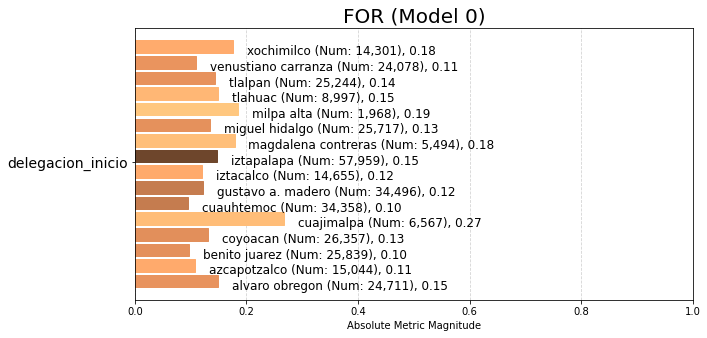

In [170]:
for_ = aeq.plot_group_metric(xtab, 'for')

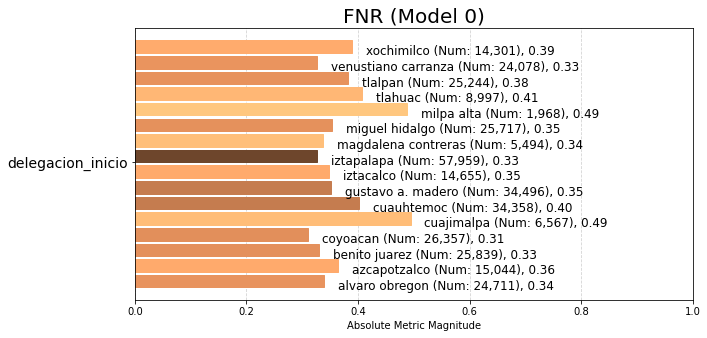

In [171]:
fnr = aeq.plot_group_metric(xtab, 'fnr')

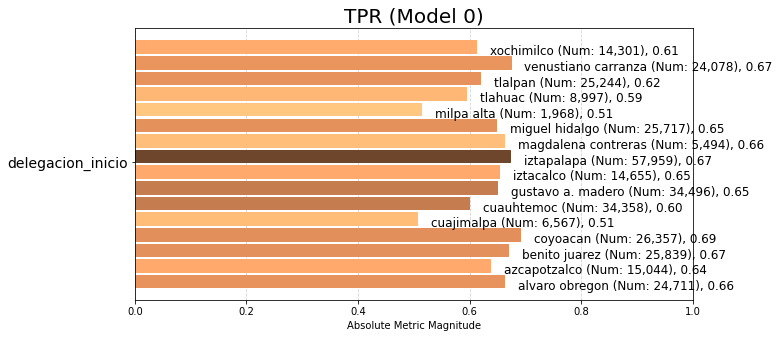

In [172]:
recall = aeq.plot_group_metric(xtab, 'tpr')

**NOTA**: la tabla de conteos de frecuencias fueron calculadas en el punto anterior.


- Las tablas de métricas obtenidas de la clase Bias de Aequitas (conteos de frecuencias y absolutas)

In [173]:
bias = Bias()

In [174]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=aequitas, 
                                        ref_groups_dict={'delegacion_inicio':'iztapalapa'}, 
                                        alpha=0.05)

get_disparity_predefined_group()


- Absolutos

In [175]:
bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion_inicio,alvaro obregon,0.42,0.99,0.98,1.01,1.01,0.99,1.03,0.98,1.00,1.00
1,delegacion_inicio,azcapotzalco,0.24,0.92,0.73,1.13,0.73,0.95,1.11,0.95,1.04,1.05
2,delegacion_inicio,benito juarez,0.42,0.94,0.74,1.12,0.66,0.96,1.01,0.99,1.03,1.06
3,delegacion_inicio,coyoacan,0.46,1.01,0.95,1.02,0.90,1.02,0.95,1.03,0.99,1.02
4,delegacion_inicio,cuajimalpa,0.09,0.79,1.37,0.83,1.82,0.76,1.51,0.75,1.19,0.86
5,delegacion_inicio,cuauhtemoc,0.47,0.79,0.72,1.13,0.65,0.81,1.23,0.89,1.15,1.06
6,delegacion_inicio,gustavo a. madero,0.54,0.91,0.88,1.05,0.83,0.92,1.07,0.96,1.06,1.03
7,delegacion_inicio,iztacalco,0.23,0.90,0.91,1.04,0.82,0.90,1.06,0.97,1.08,1.03
8,delegacion_inicio,iztapalapa,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,delegacion_inicio,magdalena contreras,0.09,0.99,1.18,0.92,1.21,0.96,1.03,0.98,1.03,0.96


- La visualización de tus 3 métricas seleccionadas con la salida de Bias (disparidad)

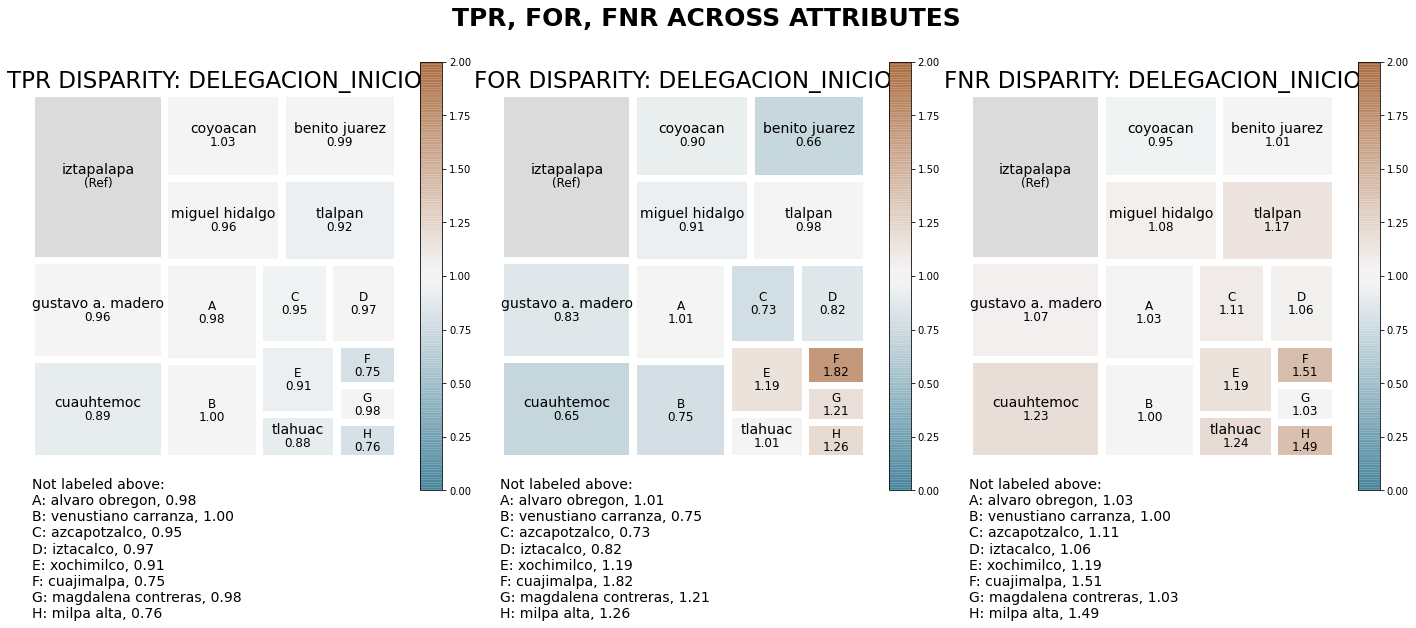

In [176]:
p = aeq.plot_disparity_all(bdf,  metrics=['tpr','for','fnr'], significance_alpha=0.05)

- Las tablas de métricas obtenidas de la clase Fairness de Aequitas (conteos de frecuencias y absolutas)

In [177]:
fair = Fairness()

In [178]:
fdf = fair.get_group_value_fairness(bdf)

In [179]:
parity_determinations = fair.list_parities(fdf)

- Absolutos

In [180]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,Supervised Fairness,Precision Parity,FOR Parity,Statistical Parity,FDR Parity,TNR Parity,Impact Parity,Unsupervised Fairness,NPV Parity,FNR Parity
0,delegacion_inicio,alvaro obregon,0.66,0.57,0.15,0.69,0.43,0.34,0.85,0.31,...,True,True,True,False,True,True,True,False,True,True
1,delegacion_inicio,azcapotzalco,0.64,0.59,0.11,0.77,0.41,0.36,0.89,0.23,...,False,False,False,False,True,True,True,False,True,True
2,delegacion_inicio,benito juarez,0.67,0.58,0.10,0.77,0.42,0.33,0.90,0.23,...,False,False,False,False,True,True,True,False,True,True
3,delegacion_inicio,coyoacan,0.69,0.56,0.13,0.70,0.44,0.31,0.87,0.30,...,True,True,True,False,True,True,True,False,True,True
4,delegacion_inicio,cuajimalpa,0.51,0.67,0.27,0.57,0.33,0.49,0.73,0.43,...,False,False,False,False,True,True,False,False,True,False
5,delegacion_inicio,cuauhtemoc,0.60,0.65,0.10,0.77,0.35,0.40,0.90,0.23,...,False,False,False,False,True,True,False,False,True,True
6,delegacion_inicio,gustavo a. madero,0.65,0.60,0.12,0.72,0.40,0.35,0.88,0.28,...,True,True,True,False,True,True,True,False,True,True
7,delegacion_inicio,iztacalco,0.65,0.61,0.12,0.71,0.39,0.35,0.88,0.29,...,True,True,True,False,True,True,True,False,True,True
8,delegacion_inicio,iztapalapa,0.67,0.57,0.15,0.68,0.43,0.33,0.85,0.32,...,True,True,True,True,True,True,True,True,True,True
9,delegacion_inicio,magdalena contreras,0.66,0.58,0.18,0.63,0.42,0.34,0.82,0.37,...,True,True,True,False,True,True,True,False,True,True


In [181]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion_inicio,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False


- La visualización de tus 3 métricas seleccionadas con la salida de Fairness (equidad)

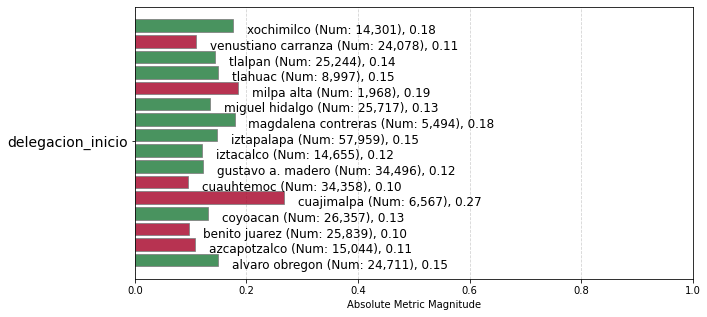

In [182]:
for_f = aeq.plot_fairness_group(fdf, group_metric='for')

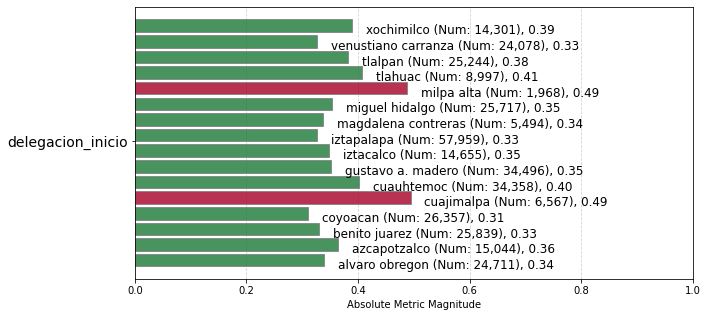

In [183]:
fnr_f = aeq.plot_fairness_group(fdf, group_metric='fnr')

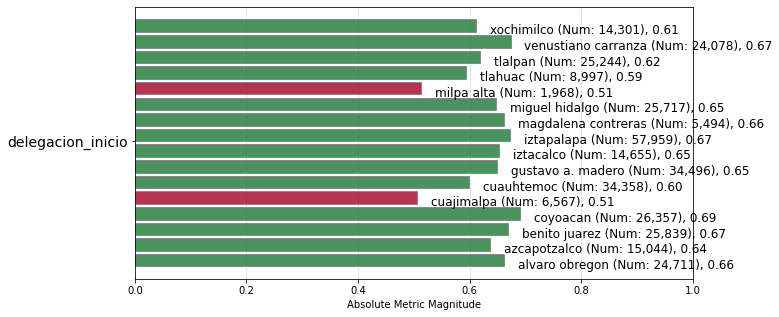

In [184]:
recall_f = aeq.plot_fairness_group(fdf, group_metric='tpr')

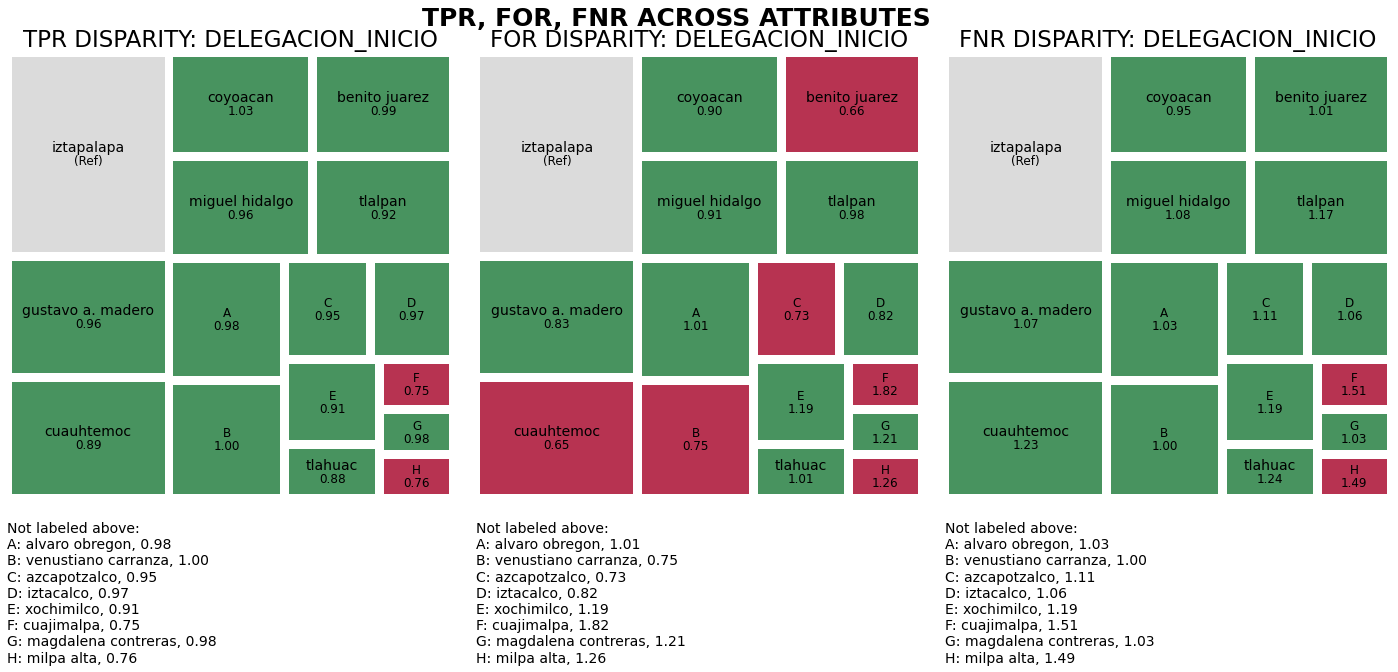

In [185]:
m = aeq.plot_fairness_disparity_all(fdf, metrics=['tpr','for','fnr'])